## Импортируем библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

**Зададим размер наших графиков**


In [3]:
sns.set(rc={'figure.figsize': (9, 6)})

In [4]:
X = pd.read_csv('X_3_30.csv')
y = pd.read_csv('y_3_30')

**Пришло время разделить наши данные.**

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

**Масштабируем данные.**

In [74]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [75]:
# конвертируем y_train из типа данных Pandas Series в массив NumPy для того чтобы позже модель смогла бы работать с соответствующими целевыми показателями.
y_train = np.array(y_train)

# Модель №1 - простой случайный лес (RF)

In [76]:
rfc_1 = RandomForestClassifier()
rfc_1.fit(X_train_scaled, y_train)
rfc_1.score(X_train_scaled, y_train)

0.9748864794736355

**Мы можем визуализировать и квантифицировать показатели важности признаков, обратившись к атрибуту feature_importances_:**

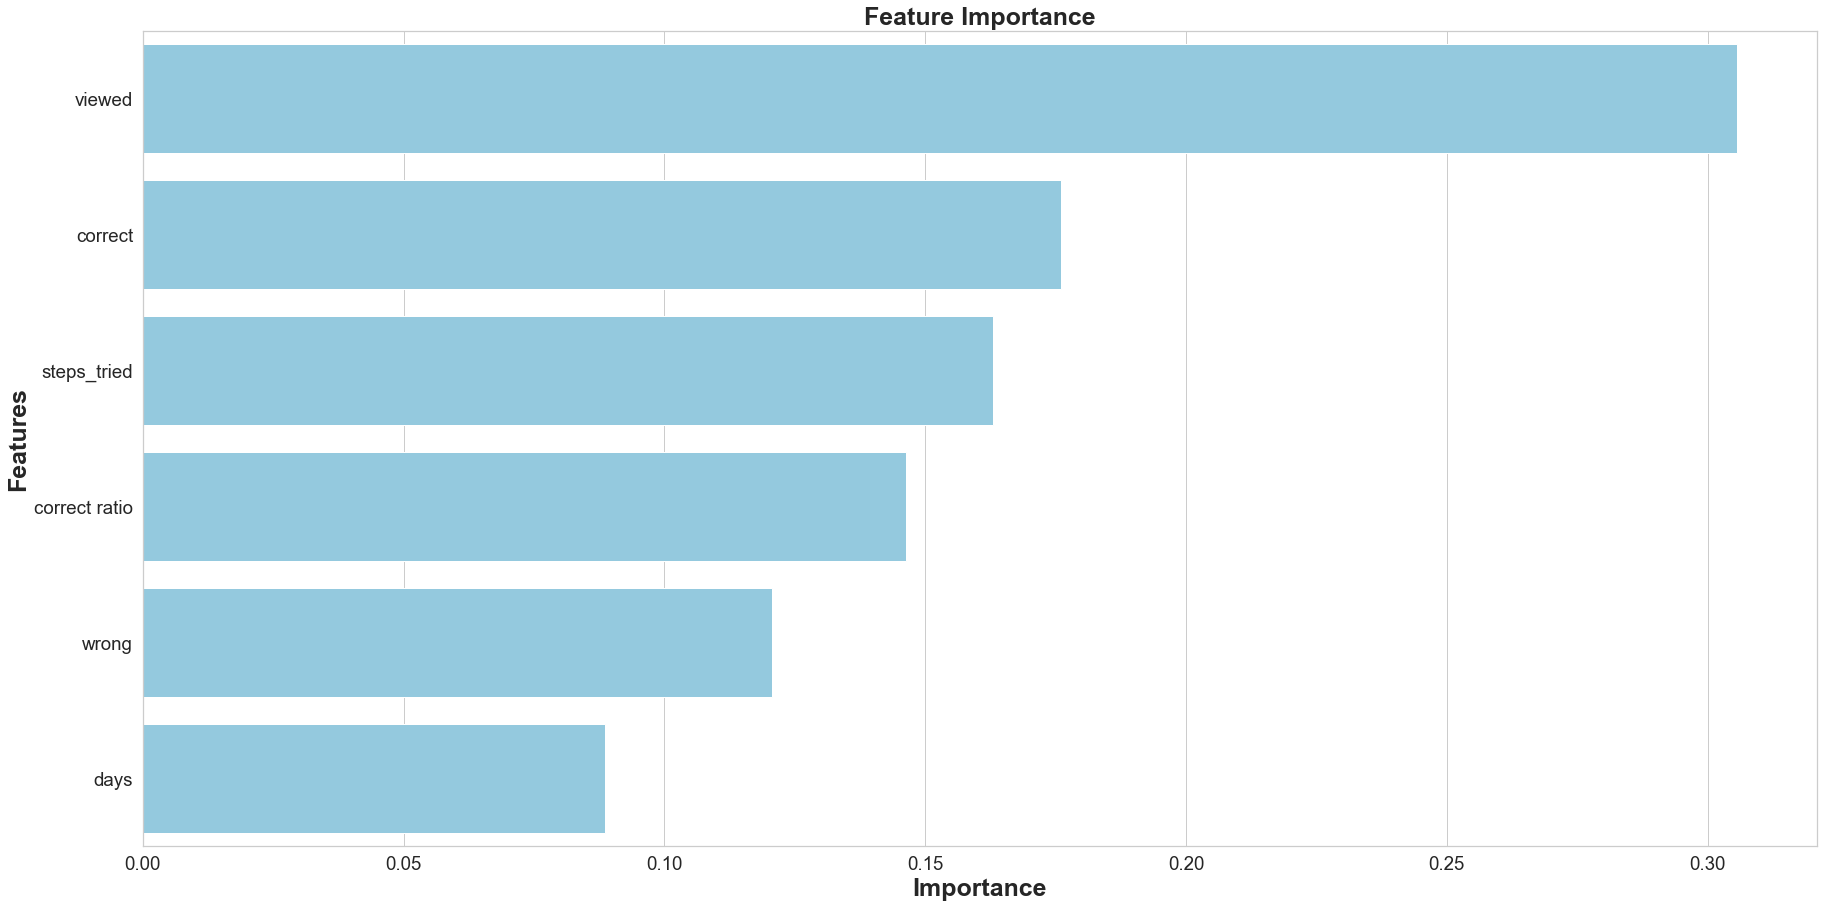

None

,Features,Gini-Importance
0,viewed,0.305600
1,correct,0.175948
2,steps_tried,0.162909
3,correct ratio,0.146252
4,wrong,0.120662
5,days,0.088629


In [77]:
feats = {}
for feature, importance in zip(X.columns, rfc_1.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

Как выяснилось, количество дней не сильно влияет на то, остался человек или дропнулся.

## Метод главных компонент

Инициализируем объект PCA (pca_test), указывая количество компонент (признаков), которые нужно рассмотреть.
Мы устанавливаем этот показатель в 6 для того, чтобы увидеть объяснённую дисперсию всех сгенерированных компонент до того, как примем решение о том, сколько компонент нам понадобится.

In [78]:
pca_test = PCA(n_components=6)

In [79]:
pca_test.fit(X_test_scaled)

PCA(n_components=6)

### Визуализируем.

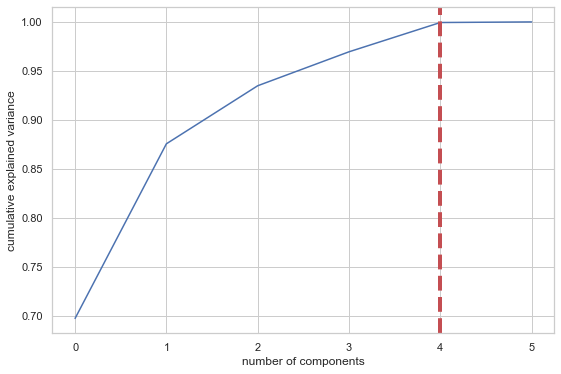

None

In [80]:
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=4, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr

Как мы видим, после того, как количество компонент становится равно 4, мы достигаем максимума кумулятивного размера объяснённой дисперсии данных. При 3-х тоже неплохо (почти 0.95). Пока что оставим 4 компоненты.

In [81]:
pca_df.head(4)

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.697363,0.697363
1,0.875594,0.178231
2,0.934849,0.059255
3,0.969503,0.034654


Этот датафрейм содержит такие показатели, как Cumulative Variance Ratio (кумулятивный размер объяснённой дисперсии данных) и Explained Variance Ratio (вклад каждой компоненты в общий объём объяснённой дисперсии)

Если взглянуть на вышеприведённый датафрейм, то окажется, что использование PCA для перехода от 6 переменных к 4 компонентам позволяет объяснить 97% дисперсии данных. Другие 2 компоненты объясняют около 3% дисперсии, а это значит, что от них мы можем отказаться. Следуя этой логике, воспользуемся PCA для уменьшения числа компонент с 6 до 4 для X_train и X_test. Запишем эти искусственно созданные наборы данных «пониженной размерности» в X_train_scaled_pca и в X_test_scaled_pca.
Это хороший способ проверки переменных, особенно когда их количество больше, чем у нас. Например, таким образом можно из 30 переменных оставить 10, которые объясняют 95% дисперсии.

In [82]:
pca = PCA(n_components=4)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

Каждая компонента — это линейная комбинация исходных переменных с соответствующими «весами». Мы можем видеть эти «веса» для каждой компоненты, создав датафрейм.

In [83]:
pca_dims = []
for i in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(i))
pca_test_df = pd.DataFrame(pca_test.components_, columns=X.columns, index=pca_dims)
pca_test_df.head(4).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3
days,0.448986,-0.261943,0.284971,0.111978
steps_tried,0.466271,0.139345,-0.384454,-0.320285
correct,0.463998,0.132055,-0.406064,-0.337111
wrong,0.329807,0.411805,0.759311,-0.250621
correct ratio,0.261960,-0.834157,0.135127,-0.094642
viewed,0.433951,0.170671,-0.106232,0.836341


# Модель №2 -  RF + PCA

Теперь мы можем передать в ещё одну базовую RF-модель данные X_train_scaled_pca и y_train и можем узнать о том, есть ли улучшения в точности предсказаний, выдаваемых моделью.

In [84]:
rfc_2 = RandomForestClassifier()
rfc_2.fit(X_train_scaled_pca, y_train)
rfc_2.score(X_train_scaled_pca, y_train)

0.9749791492910759

## Оптимизация гиперпараметров. Раунд 1: RandomizedSearchCV

In [85]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 5)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

In [86]:
rs = RandomizedSearchCV(rfc_2,
                        param_dist,
                        n_iter = 100,
                        cv = 5,
                        verbose = 1,
                        n_jobs=-1,
                        random_state=0)
rs.fit(X_train_scaled_pca, y_train)
rs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 100,
 'min_samples_split': 34,
 'min_samples_leaf': 28,
 'max_features': 'sqrt',
 'max_depth': 4,
 'bootstrap': True}

In [87]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
    'mean_fit_time',
    'std_fit_time',
    'mean_score_time',
    'std_score_time',
    'params',
    'split0_test_score',
    'split1_test_score',
    'split2_test_score',
    'std_test_score'],
    axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,100,34,28,sqrt,4,True,0.920297,0.921223,0.919748,1
1,1000,50,28,sqrt,11,True,0.920297,0.919833,0.919656,2
2,300,18,39,log2,4,True,0.920760,0.919833,0.919656,3
3,800,28,50,log2,4,True,0.920760,0.919833,0.919655,4
4,700,50,23,log2,4,True,0.919833,0.919833,0.919470,5
5,1000,7,12,sqrt,4,True,0.919370,0.919370,0.919470,6
6,800,50,44,log2,4,True,0.920760,0.919833,0.919470,7
7,200,12,50,log2,11,True,0.919833,0.918906,0.919377,8
8,500,23,39,log2,11,True,0.919370,0.919833,0.919285,9
9,400,34,7,log2,4,True,0.918443,0.919833,0.919285,10


Теперь создадим столбчатые графики, на которых, по оси Х, расположены значения гиперпараметров, а по оси Y — средние значения, показываемые моделями. Это позволит понять то, какие значения гиперпараметров, в среднем, лучше всего себя показывают.

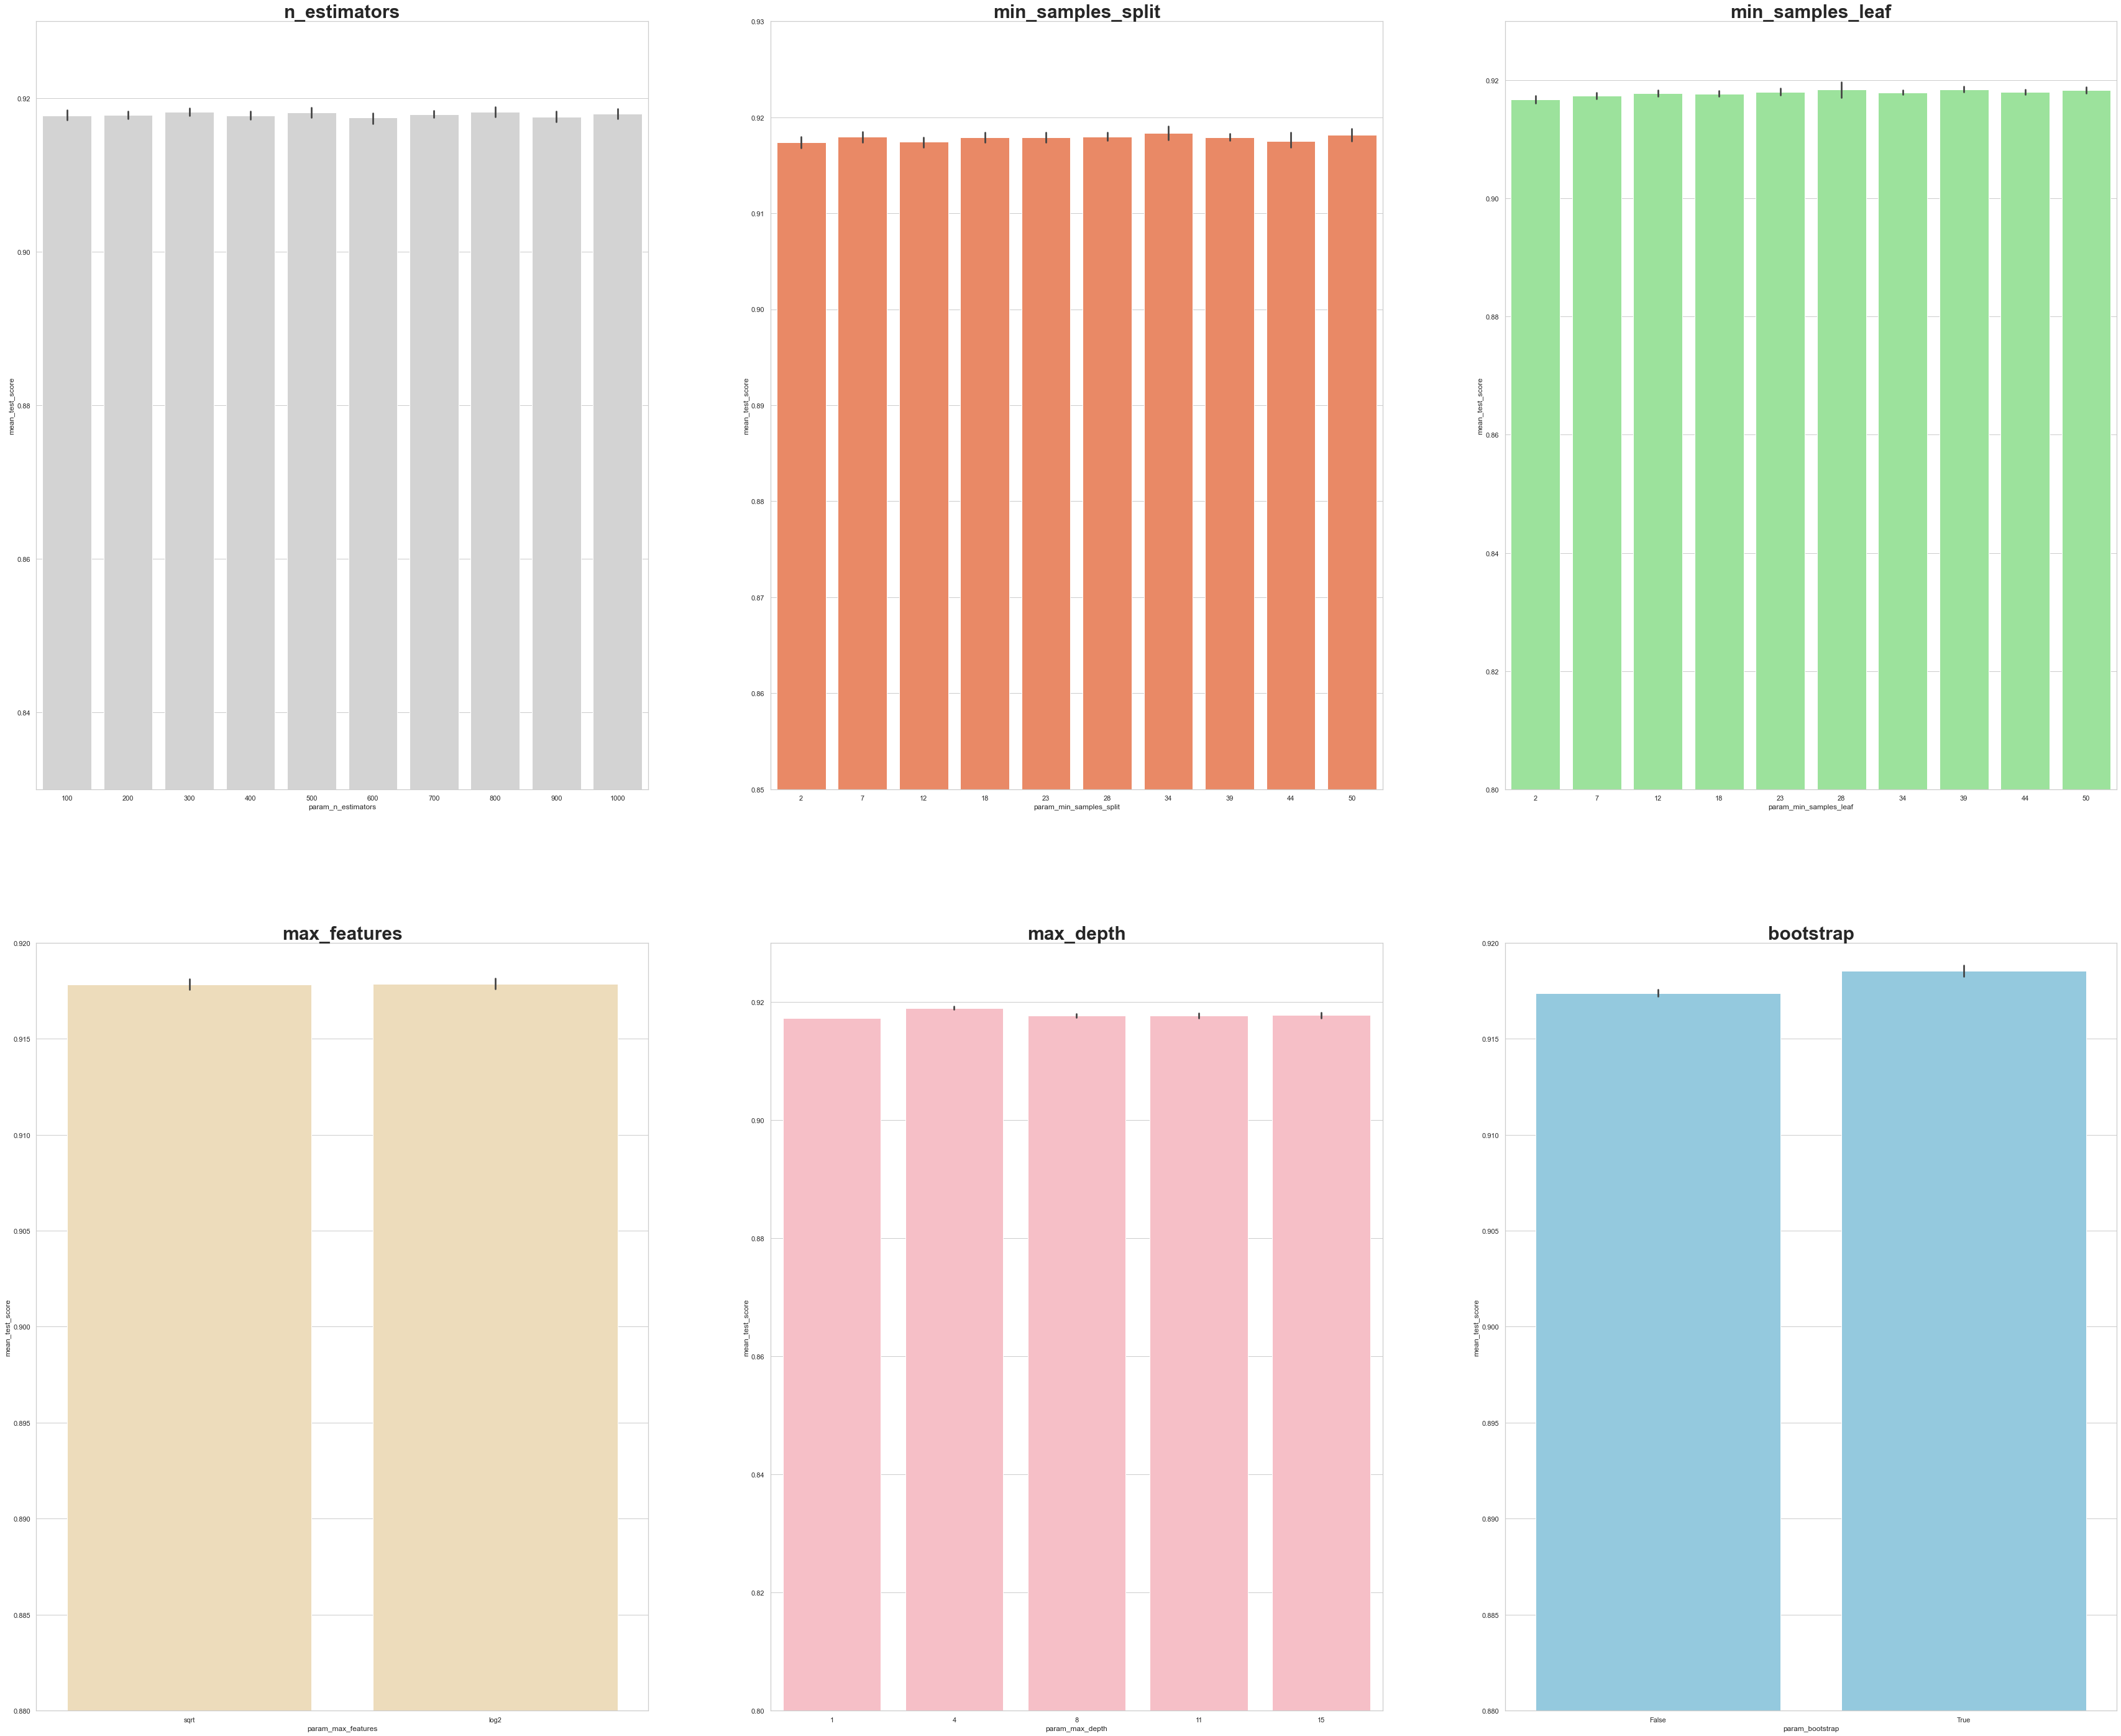

In [88]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(60,50)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.83,.93]),axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.85,.93]),axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.80,.93]),axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.88,.92]),axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.80,.93]),axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

Да уж, разброс так себе, но попробуем с этим поработать.

n_estimators: значения 300, 500 и 700, видимо, показывают наилучшие средние результаты.

min_samples_split: значения 7, 34 и 50, как кажется, показывают наилучшие результаты. Хорошо выглядит и значение 23.
Можно исследовать несколько значений этого гиперпараметра, превышающих 7, а также — несколько значений около 34.

min_samples_leaf: возникает такое ощущение, что большие значения этого гиперпараметра дают более высокие результаты.
А это значит, что мы можем испытать значения между 35 и 44, а также 23-28.

max_features: вариант log2 даёт самый высокий средний результат.

max_depth: тут чёткой зависимости между значением гиперпараметра и результатом работы модели не видно, но есть ощущение, что значения 4 выглядят неплохо.

bootstrap: значение True показывает наилучший средний результат.

In [89]:
n_estimators = [300,500,700]
max_features = ['log2']
max_depth = [3,4,5,6]
min_samples_split = [4,7,35,50]
min_samples_leaf = [23,25,27,35,40,44]
bootstrap = [True]
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

In [90]:
gs = GridSearchCV(rfc_2, param_grid, cv = 5, verbose = 1, n_jobs=-1)
gs.fit(X_train_scaled_pca, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


{'bootstrap': True,
 'max_depth': 3,
 'max_features': 'log2',
 'min_samples_leaf': 44,
 'min_samples_split': 7,
 'n_estimators': 300}

In [91]:
y_pred = rfc_1.predict(X_test_scaled)
y_pred_pca = rfc_2.predict(X_test_scaled_pca)
y_pred_gs = gs.best_estimator_.predict(X_test_scaled_pca)

In [92]:
conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_pca), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_gs), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
display('Baseline Random Forest recall score', recall_score(y_test, y_pred))
display('Baseline Random Forest precision score', precision_score(y_test, y_pred))
display(conf_matrix_baseline_pca)
display('Baseline Random Forest With PCA recall score', recall_score(y_test, y_pred_pca))
display('Baseline Random Forest With PCA precision score', precision_score(y_test, y_pred_pca))
display(conf_matrix_tuned_pca)
display('Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality recall score', recall_score(y_test, y_pred_gs))
display('Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality precision score', precision_score(y_test, y_pred_gs))

,predicted 0,predicted 1
actual 0,6470,192
actual 1,420,112


'Baseline Random Forest recall score'

0.21052631578947367

'Baseline Random Forest precision score'

0.3684210526315789

,predicted 0,predicted 1
actual 0,6507,155
actual 1,435,97


'Baseline Random Forest With PCA recall score'

0.18233082706766918

'Baseline Random Forest With PCA precision score'

0.38492063492063494

,predicted 0,predicted 1
actual 0,6638,24
actual 1,489,43


'Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality recall score'

0.08082706766917293

'Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality precision score'

0.6417910447761194

Н-н-ну, результаты не впечатляющие, однако мы пробовали предсказать поведение клиента за первые 3 дня.
Возможно, стоит попробовать предсказывать шанс того, что клиент уйдет, а не просто делать бинарную классификацию.
Также мы в очередной раз убедились в том, что Accuracy score работает только в совокупности с другими метриками.

### Пробовал тюнить параметры, особенно играл с количеством дней (и тех, после которых мы считаем, что студент дропнулся, и тех, за какой период мы пытаемся предсказать уйдет клиент или нет (но не более 5 календарных дней.)). Значит, в следующем блокноте будем пробовать делать то же с линейной регрессией.